In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

- IMDB는 인터넷 영화 데이터베이스로, 영화와 관련된 정보와 출연진 정보, 개봉 정보 등 다양한 데이터가 저장된 자료이다.
- 이미 단어들에 대한 전처리를 마친 상태이기 떄문에 굳이 tokenizing을 적용할 필요가 없다.
- 하지만 이는 매우 쉽게 접근이 가능한 데이터이고, 나중에 일반적으로 다루게될 데이터들은 보통 전처리가 되어 있지 않는 경우가 대부분이며, 직접 불필요한 'token'들을 처리해야 하는 경우가 대부분일 것이다.

- 따라서 이 파일에서는 전처리된 상태를 이용하지만 다음에는 디코딩을 한 이후에 직접 preprocessing 과정또한 직접 시도해 보고자 한다.

In [3]:
seed = 0
np.random.seed(seed)
tf.random.set_seed(3)

In [8]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words = 5000)

In [10]:
y_train[:10]

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0])

- y데이터의 형태를 보면 충분히 알 수 있겠지만 이 분석은 감정 분석이기 때문에 0,1 두 값으로 분류가 된다. 
- 따라서 긍정이면 0, 부정이면 1로 예측하게 되는 것이다.
- to_categorical을 적용해줄 필요가 없는 이유이다.

In [9]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((25000,), (25000,), (25000,), (25000,))

In [13]:
from keras.preprocessing import sequence
x_train = sequence.pad_sequences(x_train, maxlen = 100)
x_test = sequence.pad_sequences(x_test, maxlen = 100)


- model 설계에 앞서서 알아가야 할 점들이 있다.
- 이전에 이미지 학습에 쓰였던 CNN 신경망에서 conv2D, maxpooling2D layer이 사용이 됬었다.
- 그런데 이번에는 conv1, maxpooling1D layer를 사용할 예정이다.
- convolution layer이 작동하는 원리는 stride값을 설정해 주면 그 크기만큼 일종의 mask가 순차적으로 움직이면서 계속해서 중첩해 학습을 하게 된다. 이 경우에는 이미지 데이터가 아닌 텍스트 데이터이기 떄문에 1차원의 데이터이고, 따라서 한차원 낮은 convolution layer과 maxpooling layer을 이용하게 되는 것이다.

In [16]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(5000, 100))
model.add(tf.keras.layers.Dropout(rate = 0.3))
model.add(tf.keras.layers.Conv1D(64, 5, padding = 'valid', activation = 'relu', strides = 1))
model.add(tf.keras.layers.MaxPooling1D(pool_size = 4))
model.add(tf.keras.layers.LSTM(55))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         500000    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 55)                26400     
_________________________________________________________________
dense (Dense)                (None, 1)                 56        
Total params: 558,520
Trainable params: 558,520
Non-trainable params: 0
________________________________________________

In [19]:
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])
history = model.fit(x_train, y_train, validation_split = 0.2, epochs = 20)

Epoch 1/20
625/625 [==============================] - 26s 42ms/step - loss: 0.1066 - accuracy: 0.9627 - val_loss: 0.4116 - val_accuracy: 0.8488
Epoch 2/20
625/625 [==============================] - 26s 42ms/step - loss: 0.0559 - accuracy: 0.9832 - val_loss: 0.6334 - val_accuracy: 0.8416
Epoch 3/20
625/625 [==============================] - 26s 42ms/step - loss: 0.0406 - accuracy: 0.9875 - val_loss: 0.6343 - val_accuracy: 0.8338
Epoch 4/20
625/625 [==============================] - 26s 42ms/step - loss: 0.0628 - accuracy: 0.9773 - val_loss: 0.5352 - val_accuracy: 0.8408
Epoch 5/20
625/625 [==============================] - 26s 42ms/step - loss: 0.0468 - accuracy: 0.9837 - val_loss: 0.6002 - val_accuracy: 0.8388
Epoch 6/20
625/625 [==============================] - 26s 42ms/step - loss: 0.0375 - accuracy: 0.9877 - val_loss: 0.6019 - val_accuracy: 0.8410
Epoch 7/20
625/625 [==============================] - 26s 42ms/step - loss: 0.0306 - accuracy: 0.9886 - val_loss: 0.7180 - val_accuracy:

In [20]:
model.evaluate(x_test, y_test)

782/782 [==============================] - 7s 9ms/step - loss: 1.0429 - accuracy: 0.8354


[1.0429145097732544, 0.8353599905967712]

### Accuracy = 83.53%

Text(0, 0.5, 'accuracy')

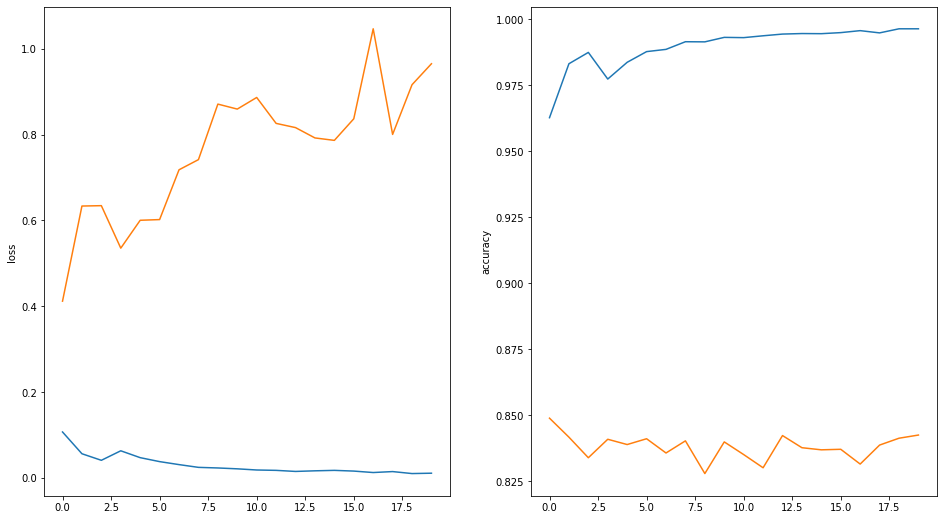

In [21]:
fig, axes = plt.subplots(1,2,figsize = (16,9))
df = pd.DataFrame(history.history)
axes[0].plot(df[['loss', 'val_loss']])
axes[0].set_ylabel('loss')
axes[1].plot(df[['accuracy', 'val_accuracy']])
axes[1].set_ylabel('accuracy')

In [26]:
correct, wrong = 0,0
pred = model.predict(x_test)
for i in range(0,len(x_test),100):
  if abs(1-pred[i]) < abs(pred[i]):predict = 1
  else:predict = 0
  print('answer:{} predict:{}'.format(y_test[i], predict))
  if y_test[i] == predict:correct+=1
  else:wrong+=1
print(correct, wrong)



answer:0 predict:0
answer:1 predict:0
answer:1 predict:1
answer:1 predict:0
answer:0 predict:0
answer:1 predict:1
answer:0 predict:0
answer:1 predict:1
answer:1 predict:1
answer:0 predict:0
answer:0 predict:0
answer:0 predict:0
answer:0 predict:0
answer:1 predict:1
answer:0 predict:0
answer:1 predict:1
answer:0 predict:0
answer:0 predict:0
answer:1 predict:1
answer:0 predict:0
answer:1 predict:1
answer:1 predict:1
answer:0 predict:0
answer:0 predict:0
answer:1 predict:1
answer:0 predict:0
answer:0 predict:0
answer:0 predict:0
answer:1 predict:1
answer:0 predict:0
answer:0 predict:0
answer:1 predict:1
answer:0 predict:0
answer:0 predict:0
answer:0 predict:1
answer:0 predict:1
answer:1 predict:1
answer:0 predict:0
answer:1 predict:1
answer:1 predict:1
answer:0 predict:0
answer:0 predict:0
answer:1 predict:1
answer:1 predict:1
answer:0 predict:0
answer:1 predict:1
answer:1 predict:1
answer:1 predict:0
answer:0 predict:0
answer:1 predict:1
answer:1 predict:1
answer:0 predict:1
answer:1 pre